In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy

# third party packages
from PIL import Image

# from my code
from src import image_tools
from src import signals_processing_tools
from src import data_tools

### find all images

In [2]:
cwd = os.getcwd()
img_names = [img_name for img_name in os.listdir(os.path.join("data", "images")) if "png" in img_name]
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', 'Screenshot 2022-10-26 123946.png', 'Screenshot 2022-10-26 124245.png', '124245.png', '124105.png', 'Screenshot 2022-10-26 124105.png', '124205.png', 'Screenshot 2022-10-26 124205.png'])

### import image

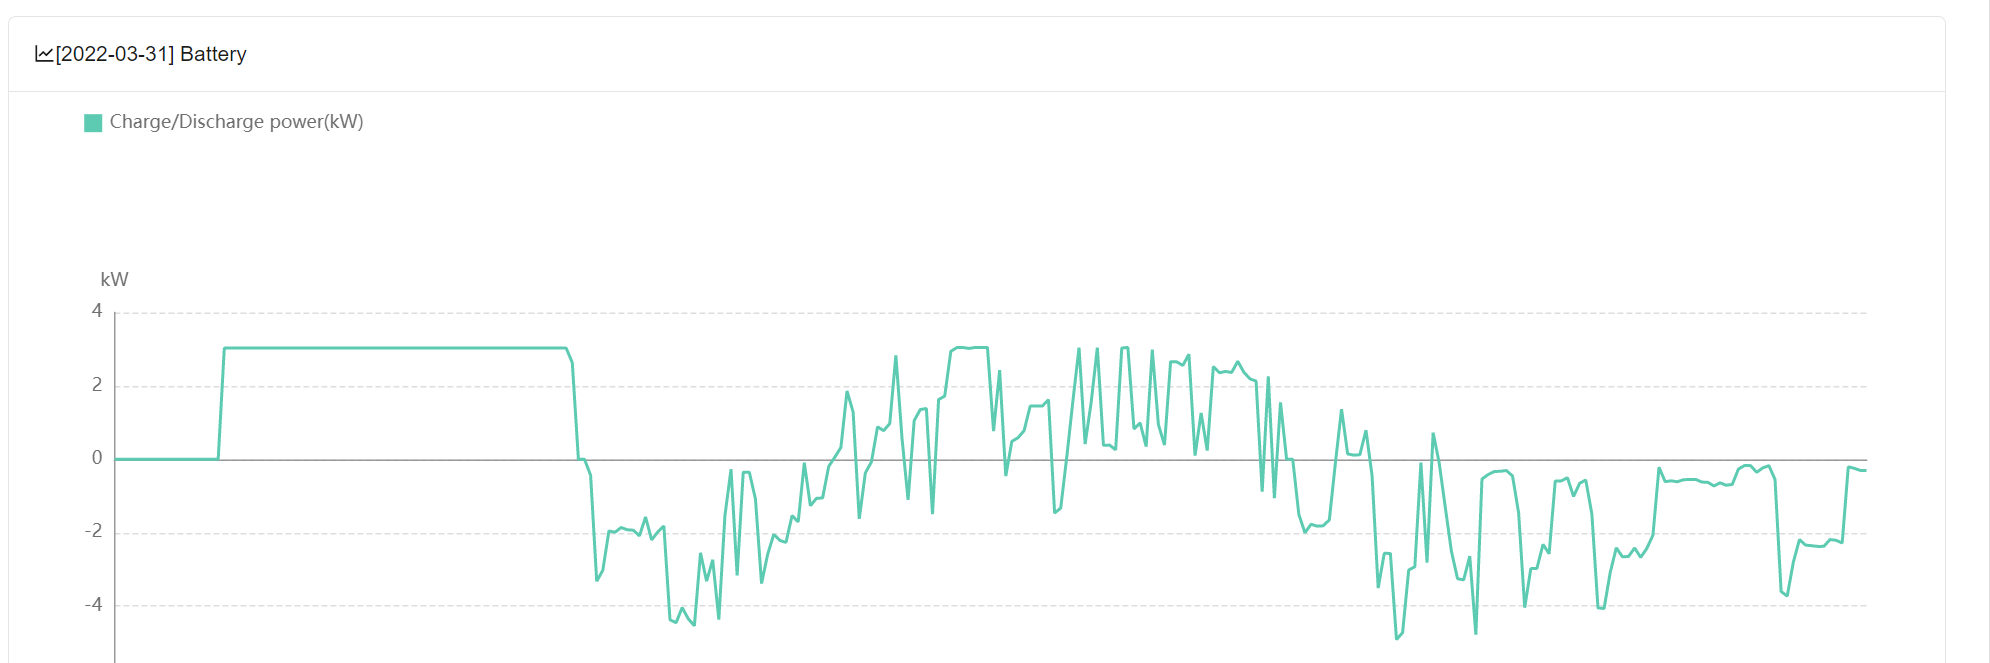

In [3]:
# exract the image
img = Image.open(img_paths[img_names[0]]).convert("RGB")

# show the image
img

## find the grid axes lines

### convolve image with horizontal filter kernel

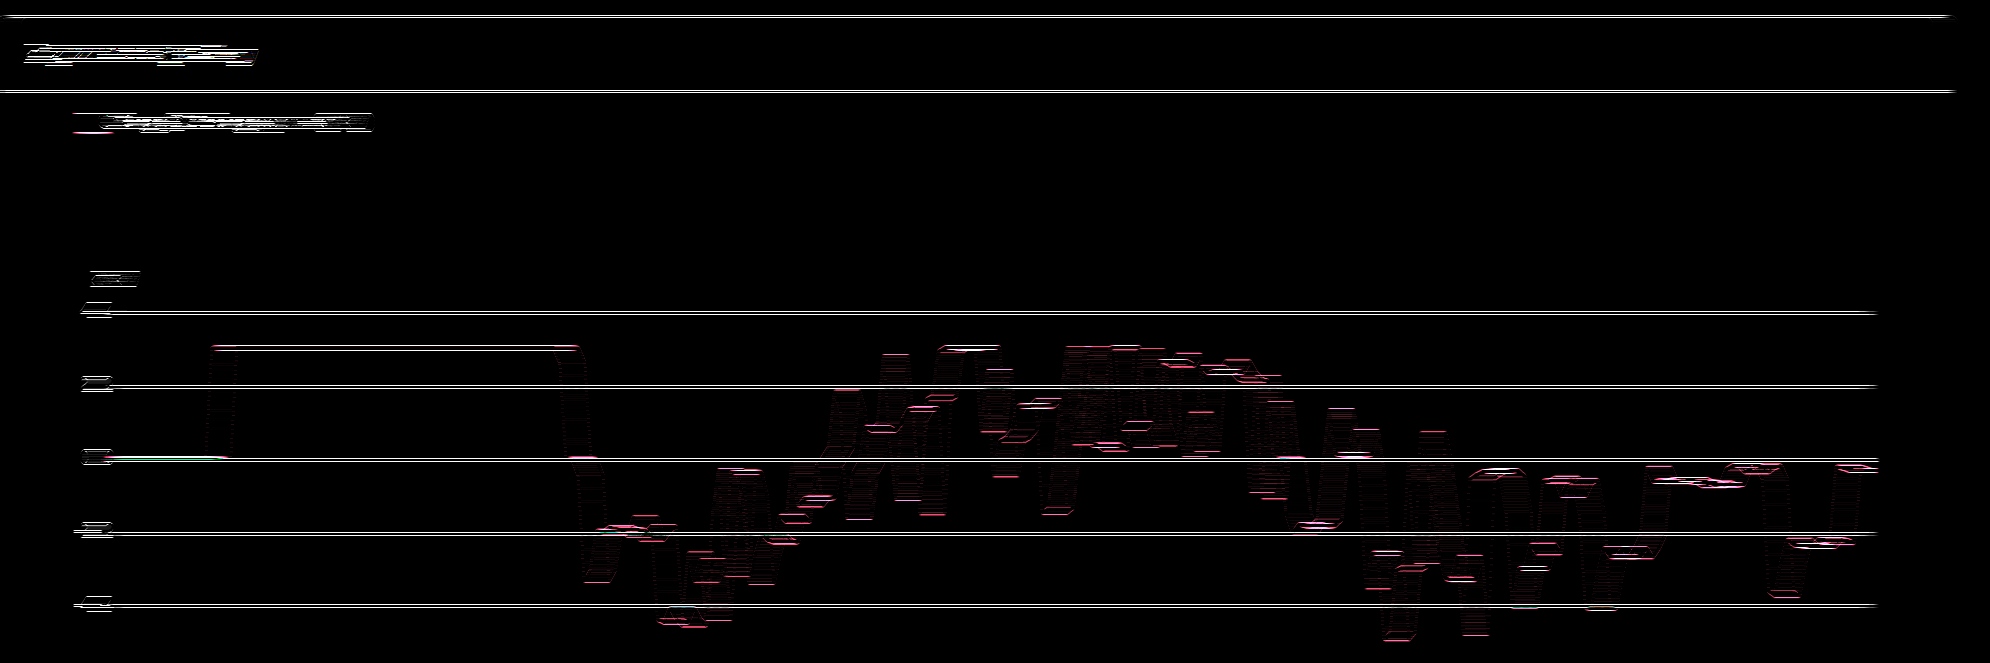

In [4]:
img_convolved_horizontal_filter = image_tools.convolve_image_horizontal_filter(img) 
img_height = img_convolved_horizontal_filter.shape[0]
img_width = img_convolved_horizontal_filter.shape[1]
Image.fromarray(img_convolved_horizontal_filter)

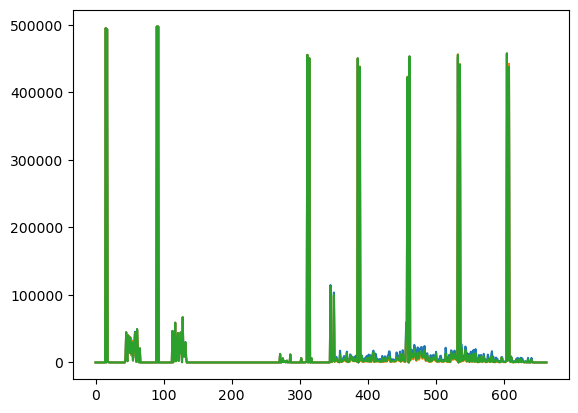

In [5]:
# calculate sum of response in horizontal direction
sum_arr_along_x = np.sum(img_convolved_horizontal_filter, axis=1)
plt.plot(sum_arr_along_x)

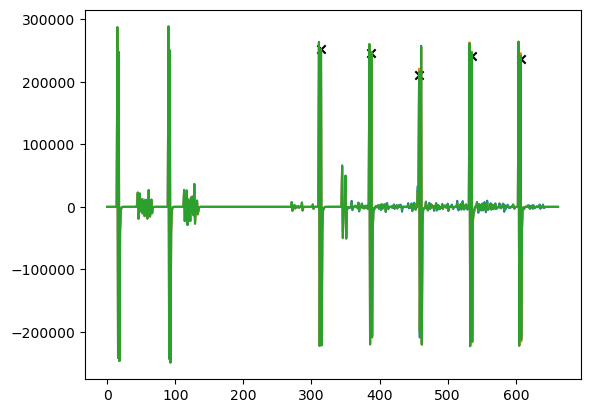

In [6]:
filtered_sum_arr_along_x = signals_processing_tools.remove_baseline_wander(sum_arr_along_x)
plt.plot(filtered_sum_arr_along_x)

peaks_x, peaks_y = signals_processing_tools.find_peaks(filtered_sum_arr_along_x)
plt.scatter(peaks_x, peaks_y, marker='x', c='black')

Picture this plot rotated 90 degrees clockwise, and then along the y axis of the image above. The peaks correspond to high sum of response along the x axis when the image was convolved with a horizontal filter. Therefore, peaks here correspond to rows along the original image with a lot of 'horizontalness' (highest values are just straight horizontal lines).

Clearly, the 5 peaks identified between 300- 600 correspond to the Y values on the plot of 4, 2, 0, -2, -4.

For an unkown reason, the slightly lower peak corresponds more closely to the exact point in the plots where the y axes grid lines are. This is perhaps because the borders of the exes grid lines are detected stronger than the middle of the lines, due to filter choices. This can be explained with a diagram on request (picture the kernel passing over a line a couple pixels thick)

In [7]:
y_coord_dict, _, _ = data_tools.generate_dict_y_coords_for_kW(peaks_x)
y_coord_dict

{4: 606, 2: 533, 0: 460, -2: 386, -4: 313}

### Check the values found for y grid axis

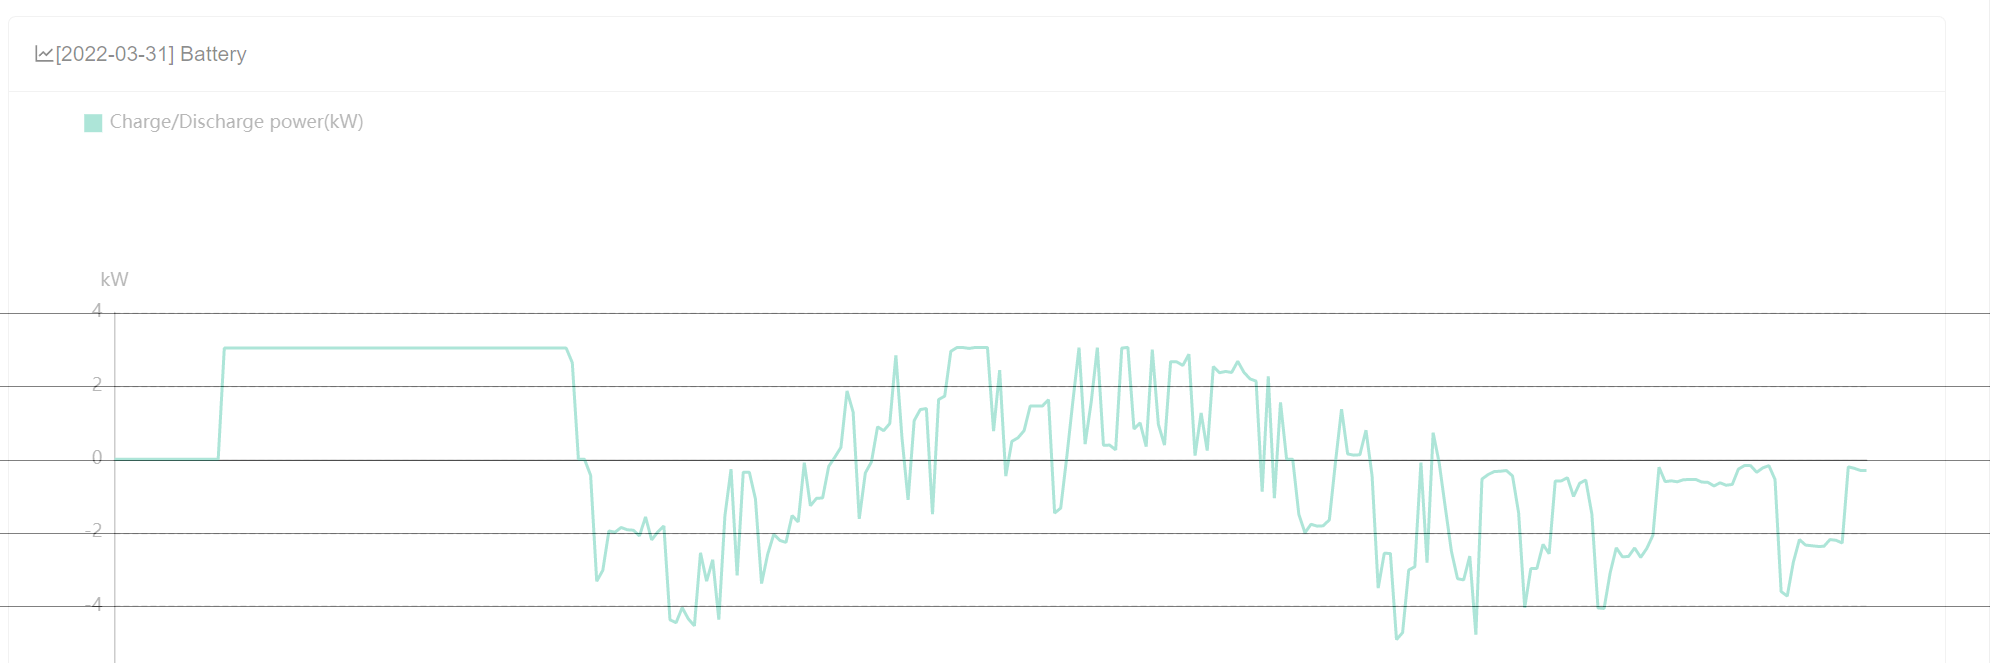

In [8]:
img_arr = np.asarray(img)

# generate white page with black lines image for pasting on top of original image, for reference
black_line_pix_values = np.zeros((1,img_width,3), dtype="uint8")
white_image = np.ones(np.shape(img_arr),dtype="uint8")*255
for y_val in y_coord_dict:
    white_image[y_coord_dict[y_val]] =  black_line_pix_values
    
lines = Image.fromarray(white_image)
img_with_lines = img.copy()
lines.putalpha(127) # make partially transparent

# paste the two images together
img_with_lines.paste(lines, (0,0), lines)
img_with_lines

From the above image of the original plots, and original grid, with the prediced grid locations overlayed, we can see the predictions are accurate and these pixel values can be used for calculations in the y axis.